In [16]:
import pandas as pd
import numpy as np
import torch.nn as nn
import torch 
from torch.autograd import Variable 
from matplotlib import pyplot as plt
import torch.nn.functional as F
import time
from statistics import mean
from sklearn import preprocessing
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import scale
from sklearn import metrics
from sklearn.preprocessing import label_binarize
from scipy.stats import mode
from scipy import interp

In [17]:
def encode(data, col, max_val):
    data[col + '_sin'] = np.sin(2 * np.pi * data[col]/max_val)
    data[col + '_cos'] = np.cos(2 * np.pi * data[col]/max_val)
    return data

In [18]:
# Read in data from small csv to a dataframe
df1=pd.read_csv('weather_medium.csv', sep=',')

# Reformat data in date/time column 
df1['Formatted Date'] =  pd.to_datetime(df1['Formatted Date'])

# Create a new column for year / month / hour
df1['Year'] = pd.DatetimeIndex(df1['Formatted Date']).year
df1['Month'] = pd.DatetimeIndex(df1['Formatted Date']).month
df1['Hour'] = pd.DatetimeIndex(df1['Formatted Date']).hour

# Encode month and hour for cyclical nature
df1 = encode(df1, 'Month', 13)
df1 = encode(df1, 'Hour', 23)
df1 = encode(df1, 'Wind Bearing (degrees)', 359)

# Remove original date/time column
df1=df1.drop(['Formatted Date'],axis=1)

# Convert columns to factors
df1['Summary'] = df1['Summary'].astype('category')
df1['Precip Type'] = df1['Precip Type'].astype('category')
df1['Daily Summary'] = df1['Daily Summary'].astype('category')

# Create a column stating whether its mostly cloudy / overcast or not in summary
df1['Heavy_Cloud'] = pd.np.where(df1.Summary.str.contains("Mostly Cloudy"), 1,
                    pd.np.where(df1.Summary.str.contains("Overcast"), 1,
                    pd.np.where(df1.Summary.str.contains("Foggy"), 1,0)))

# Convert to boolean and print count
df1['Heavy_Cloud']=df1['Heavy_Cloud'].astype('bool')

# Create a column stating whether its mostly cloudy / overcast or not in summary
df1['New_Summary'] = pd.np.where(df1.Summary.str.contains("Mostly Cloudy"), 0,
                    pd.np.where(df1.Summary.str.contains("Overcast"), 0,
                    pd.np.where(df1.Summary.str.contains("Foggy"), 0,
                    pd.np.where(df1.Summary.str.contains("Rain"), 0,
                    pd.np.where(df1.Summary.str.contains("Drizzle"), 0,            
                    pd.np.where(df1.Summary.str.contains("Partly Cloudy"), 1,2))))))

# Convert to boolean and print count
df1['New_Summary']=df1['New_Summary'].astype('category')

In [19]:
y=df1["New_Summary"]
X=scale(df1[['Temperature (C)','Apparent Temperature (C)','Humidity','Month_sin','Month_cos']])
X = pd.DataFrame(data=X)

In [20]:

num = len(df1)
indices = list(range(num))
split = int(max(indices)*0.1)

test_idx = np.random.choice(indices, size=split, replace=False)

inter_idx = list(set(indices) - set(test_idx))

num = len(inter_idx)
indices = list(range(num))
split = int(max(indices)*0.22)

valid_idx = np.random.choice(inter_idx, size=split, replace=False)
train_idx = list(set(inter_idx) - set(valid_idx))

x_train = np.array(X.loc[train_idx,:], dtype=np.float32)
x_train = x_train.reshape(-1, 1)

y_train = np.array(y[train_idx], dtype=np.float32)
y_train = y_train.reshape(-1, 1)

x_valid = np.array(X.loc[valid_idx,:], dtype=np.float32)
x_valid = x_valid.reshape(-1, 1)

y_valid = np.array(y[valid_idx], dtype=np.float32)
y_valid = y_valid.reshape(-1, 1)

x_test = np.array(X.loc[test_idx,:], dtype=np.float32)
x_test = x_test.reshape(-1, 1)

y_test = np.array(y[test_idx], dtype=np.float32)
y_test = y_test.reshape(-1, 1)

print('train: {}% | validation: {}% | test {}%'.format(round(len(y_train)/len(df1),2),
                                                       round(len(y_valid)/len(df1),2),
                                                       round(len(y_test)/len(df1),2)))

train: 0.7% | validation: 0.2% | test 0.1%


In [21]:
x_train = Variable(torch.Tensor(x_train))
x_train=x_train.view(-1,5)
y_train = Variable(torch.Tensor(y_train))

x_valid = Variable(torch.Tensor(x_valid))
x_valid=x_valid.view(-1,5)

x_test = Variable(torch.Tensor(x_test))
x_test=x_test.view(-1,5)


n = x_train.size(0)
m = x_valid.size(0)
m_test = x_test.size(0)
d = x_train.size(1)

x_train_new = x_train.unsqueeze(1).expand(n, m, d)
x_train_new_test = x_train.unsqueeze(1).expand(n, m_test, d)
x_valid_new = x_valid.unsqueeze(0).expand(n, m, d)
x_test_new = x_test.unsqueeze(0).expand(n, m_test, d)

start_time = time.clock()
dist = torch.pow(x_train_new - x_valid_new, 2).sum(2)
val, index = dist.topk(10,dim=0, largest=False, sorted=True)
print (time.clock() - start_time, "seconds")

dist_test = torch.pow(x_train_new_test - x_test_new, 2).sum(2)
val_test, index_test = dist_test.topk(10,dim=0, largest=False, sorted=True)

index=torch.transpose(index,dim0=0,dim1=1)
index_test=torch.transpose(index_test,dim0=0,dim1=1)

predictions=y_train[index]
predictions=predictions.detach().numpy()

predictions_test=y_train[index_test]
predictions_test=predictions_test.detach().numpy()


a=mode(predictions, axis=1)
a=(np.squeeze(a))
a=np.transpose(a)
a=np.delete(a, np.s_[1], axis=1)


a_test=mode(predictions_test, axis=1)
a_test=(np.squeeze(a_test))
a_test=np.transpose(a_test)
a_test=np.delete(a_test, np.s_[1], axis=1)


# y_valid=y_valid.detach().numpy()

4.358996000000001 seconds


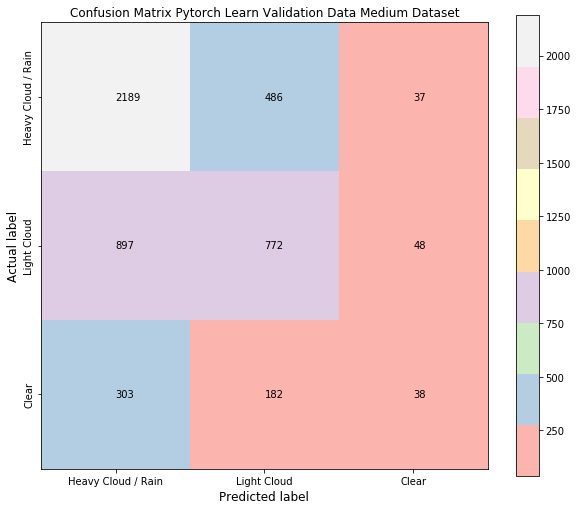

In [22]:
# Confusion Matrix
cm = metrics.confusion_matrix(y_valid, a)
plt.figure(figsize=(10,8))
plt.imshow(cm, interpolation='nearest', cmap='Pastel1')
plt.title('Confusion Matrix Pytorch Learn Validation Data Medium Dataset', size = 12)
plt.colorbar()
tick_marks = np.arange(3)
plt.xticks(tick_marks, ["Heavy Cloud / Rain", "Light Cloud", "Clear"], size = 10,rotation=0)
plt.yticks(tick_marks, ["Heavy Cloud / Rain", "Light Cloud", "Clear"], size = 10,rotation=90,verticalalignment='center')
# plt.axis["left"].major_ticklabels.set_ha("center")
plt.tight_layout()
plt.ylabel('Actual label', size = 12)
plt.xlabel('Predicted label', size = 12)
width, height = cm.shape
for x in range(width):
 for y in range(height):
  plt.annotate(str(cm[x][y]), xy=(y, x), 
  horizontalalignment='centre',
  verticalalignment='center')

plt.subplots_adjust(top=0.9, bottom=0.1, left=0.125, right=0.9, hspace=0.7 ,wspace=0.5)
plt.savefig('KNN_Validation_Confusion_Matrix_Medium_PT.png',pdi=600)

In [23]:
Score=metrics.accuracy_score(y_valid, a)
ERR=1-Score

Recall_Heavy_Cloud=(cm[0,0])/(np.sum(cm,axis=1)[0])
FNR_Heavy_Cloud=1-Recall_Heavy_Cloud
FPR_Heavy_Cloud=((cm[1,0])+cm[2,0])/((np.sum(cm,axis=1)[1])+(np.sum(cm,axis=1)[2]))
Specificity_Heavy_Cloud=1-FPR_Heavy_Cloud

Recall_Light_Cloud=(cm[1,1])/(np.sum(cm,axis=1)[1])
FNR_Light_Cloud=1-Recall_Light_Cloud
FPR_Light_Cloud=((cm[0,1])+cm[2,1])/((np.sum(cm,axis=1)[0])+(np.sum(cm,axis=1)[2]))
Specificity_Light_Cloud=1-FPR_Light_Cloud

Recall_Clear=(cm[2,2])/(np.sum(cm,axis=1)[2])
FNR_Clear=1-Recall_Clear
FPR_Clear=((cm[0,2])+cm[1,2])/((np.sum(cm,axis=1)[0])+(np.sum(cm,axis=1)[1]))
Specificity_Clear=1-FPR_Clear


print('Score of validation model: ',Score)
print('Error rate of validation model: ',ERR)

print('\nRecall / TPR (Clear) of validation model: ',Recall_Clear)
print('FNR (Clear) of validation model: ',FNR_Clear)
print('Specificity / TNR (Clear) of validation model: ',Specificity_Clear)
print('FPR (Clear) of validation model: ',FPR_Clear)

print('\nRecall / TPR (Light Cloud) of validation model: ',Recall_Light_Cloud)
print('FNR (Light Cloud) of validation model: ',FNR_Light_Cloud)
print('Specificity / TNR (Light Cloud) of validation model: ',Specificity_Light_Cloud)
print('FPR (Light Cloud) of validation model: ',FPR_Light_Cloud)

print('\nRecall / TPR (Heavy Cloud / Rain) of validation model: ',Recall_Heavy_Cloud)
print('FNR (Heavy Cloud / Rain) of validation model: ',FNR_Heavy_Cloud)
print('Specificity / TNR (Heavy Cloud / Rain) of validation model: ',Specificity_Heavy_Cloud)
print('FPR (Heavy Cloud / Rain) of validation model: ',FPR_Heavy_Cloud)



Score of validation model:  0.6056138933764136
Error rate of validation model:  0.3943861066235864

Recall / TPR (Clear) of validation model:  0.07265774378585087
FNR (Clear) of validation model:  0.9273422562141491
Specificity / TNR (Clear) of validation model:  0.9808083088733348
FPR (Clear) of validation model:  0.01919169112666516

Recall / TPR (Light Cloud) of validation model:  0.44962143273150845
FNR (Light Cloud) of validation model:  0.5503785672684915
Specificity / TNR (Light Cloud) of validation model:  0.7935085007727976
FPR (Light Cloud) of validation model:  0.20649149922720247

Recall / TPR (Heavy Cloud / Rain) of validation model:  0.8071533923303835
FNR (Heavy Cloud / Rain) of validation model:  0.19284660766961648
Specificity / TNR (Heavy Cloud / Rain) of validation model:  0.4642857142857143
FPR (Heavy Cloud / Rain) of validation model:  0.5357142857142857


In [24]:
y_valid_bin = label_binarize(y_valid, classes=[0,1,2])
predictions_bin=label_binarize(a,classes=[0,1,2])

n_classes = y_valid_bin.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_valid_bin[:, i], predictions_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_valid_bin.ravel(), predictions_bin.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])


print("AUC of Clear validation model",roc_auc[2])
print("AUC of Light Cloud validation model",roc_auc[1])
print("AUC of Heavy Cloud / Rain validation model",roc_auc[0])
print("AUC of micro average validation model",roc_auc["micro"])
print("AUC of macro average validation model",roc_auc["macro"])



AUC of Clear validation model 0.5267330263295928
AUC of Light Cloud validation model 0.621564966752153
AUC of Heavy Cloud / Rain validation model 0.6357195533080489
AUC of micro average validation model 0.7042104200323103
AUC of macro average validation model 0.594672515463265


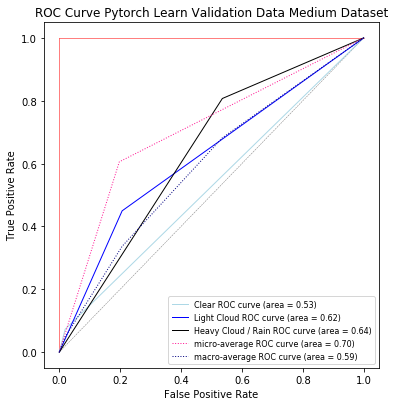

In [25]:
# Plot all ROC curves
fig, ax1=plt.subplots(figsize=(6,6))
x1 = [0, 0]
x2 = [0,1]
y1=[0,1]
y2=[1,1]
ax1.plot(x1, y1, 'red',linewidth=0.5)
ax1.plot(x2, y2, 'red',linewidth=0.5)
ax1.plot(x2, y1, 'grey',linestyle='--',linewidth=0.5)

ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('ROC Curve Pytorch Learn Validation Data Medium Dataset')

ax1.plot(fpr[2],tpr[2],
         label='Clear ROC curve (area = {0:0.2f})'
              ''.format(roc_auc[2]),
         color='lightblue',linewidth=1)

ax1.plot(fpr[1],tpr[1],
         label='Light Cloud ROC curve (area = {0:0.2f})'
              ''.format(roc_auc[1]),
         color='blue',linewidth=1)

ax1.plot(fpr[0],tpr[0],
         label='Heavy Cloud / Rain ROC curve (area = {0:0.2f})'
              ''.format(roc_auc[0]),
         color='black',linewidth=1)


ax1.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
                ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=1)

ax1.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=1)

ax1.legend(loc="lower right",fontsize=8)

fig.subplots_adjust(top=0.9, bottom=0.1, left=0.125, right=0.9, hspace=0.7 ,wspace=0.5)
fig.savefig('KNN_Validation_ROC_Medium_PT.png',pdi=600)

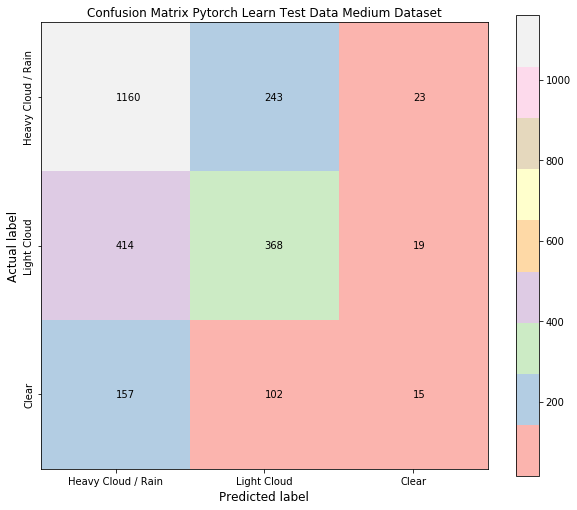

In [26]:
# Confusion Matrix
cm2 = metrics.confusion_matrix(y_test, a_test)
plt.figure(figsize=(10,8))
plt.imshow(cm2, interpolation='nearest', cmap='Pastel1')
plt.title('Confusion Matrix Pytorch Learn Test Data Medium Dataset', size = 12)
plt.colorbar()
tick_marks = np.arange(3)
plt.xticks(tick_marks, ["Heavy Cloud / Rain", "Light Cloud", "Clear"], size = 10,rotation=0)
plt.yticks(tick_marks, ["Heavy Cloud / Rain", "Light Cloud", "Clear"], size = 10,rotation=90,verticalalignment='center')
# plt.axis["left"].major_ticklabels.set_ha("center")
plt.tight_layout()
plt.ylabel('Actual label', size = 12)
plt.xlabel('Predicted label', size = 12)
width, height = cm2.shape
for x in range(width):
 for y in range(height):
  plt.annotate(str(cm2[x][y]), xy=(y, x), 
  horizontalalignment='centre',
  verticalalignment='center')

plt.subplots_adjust(top=0.9, bottom=0.1, left=0.125, right=0.9, hspace=0.7 ,wspace=0.5)
plt.savefig('KNN_Test_Confusion_Matrix_Medium_PT.png',pdi=600)

In [27]:
Score=metrics.accuracy_score(y_test, a_test)
ERR=1-Score

Recall_Heavy_Cloud=(cm2[0,0])/(np.sum(cm2,axis=1)[0])
FNR_Heavy_Cloud=1-Recall_Heavy_Cloud
FPR_Heavy_Cloud=((cm2[1,0])+cm2[2,0])/((np.sum(cm2,axis=1)[1])+(np.sum(cm2,axis=1)[2]))
Specificity_Heavy_Cloud=1-FPR_Heavy_Cloud

Recall_Light_Cloud=(cm2[1,1])/(np.sum(cm2,axis=1)[1])
FNR_Light_Cloud=1-Recall_Light_Cloud
FPR_Light_Cloud=((cm2[0,1])+cm2[2,1])/((np.sum(cm2,axis=1)[0])+(np.sum(cm2,axis=1)[2]))
Specificity_Light_Cloud=1-FPR_Light_Cloud

Recall_Clear=(cm2[2,2])/(np.sum(cm2,axis=1)[2])
FNR_Clear=1-Recall_Clear
FPR_Clear=((cm2[0,2])+cm2[1,2])/((np.sum(cm2,axis=1)[0])+(np.sum(cm2,axis=1)[1]))
Specificity_Clear=1-FPR_Clear


print('Score of test model: ',Score)
print('Error rate of test model: ',ERR)

print('\nRecall / TPR (Clear) of test model: ',Recall_Clear)
print('FNR (Clear) of test model: ',FNR_Clear)
print('Specificity / TNR (Clear) of test model: ',Specificity_Clear)
print('FPR (Clear) of test model: ',FPR_Clear)

print('\nRecall / TPR (Light Cloud) of test model: ',Recall_Light_Cloud)
print('FNR (Light Cloud) of test model: ',FNR_Light_Cloud)
print('Specificity / TNR (Light Cloud) of test model: ',Specificity_Light_Cloud)
print('FPR (Light Cloud) of test model: ',FPR_Light_Cloud)

print('\nRecall / TPR (Heavy Cloud / Rain) of test model: ',Recall_Heavy_Cloud)
print('FNR (Heavy Cloud / Rain) of test model: ',FNR_Heavy_Cloud)
print('Specificity / TNR (Heavy Cloud / Rain) of test model: ',Specificity_Heavy_Cloud)
print('FPR (Heavy Cloud / Rain) of test model: ',FPR_Heavy_Cloud)

Score of test model:  0.616953218712515
Error rate of test model:  0.38304678128748504

Recall / TPR (Clear) of test model:  0.05474452554744526
FNR (Clear) of test model:  0.9452554744525548
Specificity / TNR (Clear) of test model:  0.9811405478221823
FPR (Clear) of test model:  0.018859452177817693

Recall / TPR (Light Cloud) of test model:  0.45942571785268416
FNR (Light Cloud) of test model:  0.5405742821473158
Specificity / TNR (Light Cloud) of test model:  0.7970588235294118
FPR (Light Cloud) of test model:  0.20294117647058824

Recall / TPR (Heavy Cloud / Rain) of test model:  0.8134642356241234
FNR (Heavy Cloud / Rain) of test model:  0.1865357643758766
Specificity / TNR (Heavy Cloud / Rain) of test model:  0.46883720930232553
FPR (Heavy Cloud / Rain) of test model:  0.5311627906976745


In [28]:
y_test_bin = label_binarize(y_test, classes=[0,1,2])
predictions_test_bin=label_binarize(a_test,classes=[0,1,2])

n_classes = y_test_bin.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], predictions_test_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), predictions_test_bin.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])


print("AUC of Clear test model",roc_auc[2])
print("AUC of Light Cloud test model",roc_auc[1])
print("AUC of Heavy Cloud / Rain test model",roc_auc[0])
print("AUC of micro average test model",roc_auc["micro"])
print("AUC of macro average test model",roc_auc["macro"])

AUC of Clear test model 0.5179425366848138
AUC of Light Cloud test model 0.628242270691048
AUC of Heavy Cloud / Rain test model 0.6411507224632245
AUC of micro average test model 0.7127149140343861
AUC of macro average test model 0.595778509946362


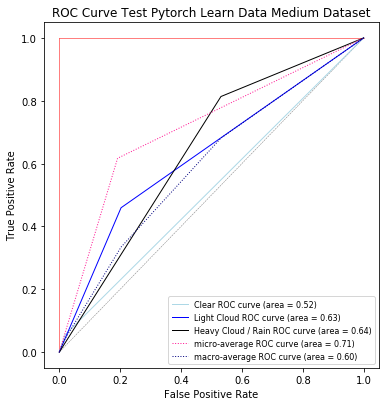

In [29]:
# Plot all ROC curves
fig, ax1=plt.subplots(figsize=(6,6))
x1 = [0, 0]
x2 = [0,1]
y1=[0,1]
y2=[1,1]
ax1.plot(x1, y1, 'red',linewidth=0.5)
ax1.plot(x2, y2, 'red',linewidth=0.5)
ax1.plot(x2, y1, 'grey',linestyle='--',linewidth=0.5)

ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('ROC Curve Test Pytorch Learn Data Medium Dataset')

ax1.plot(fpr[2],tpr[2],
         label='Clear ROC curve (area = {0:0.2f})'
              ''.format(roc_auc[2]),
         color='lightblue',linewidth=1)

ax1.plot(fpr[1],tpr[1],
         label='Light Cloud ROC curve (area = {0:0.2f})'
              ''.format(roc_auc[1]),
         color='blue',linewidth=1)

ax1.plot(fpr[0],tpr[0],
         label='Heavy Cloud / Rain ROC curve (area = {0:0.2f})'
              ''.format(roc_auc[0]),
         color='black',linewidth=1)

ax1.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
                ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=1)

ax1.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=1)

ax1.legend(loc="lower right",fontsize=8)

fig.subplots_adjust(top=0.9, bottom=0.1, left=0.125, right=0.9, hspace=0.7 ,wspace=0.5)
fig.savefig('KNN_Test_ROC_Medium_PT.png',pdi=600)